importing the dataset to notebook environment

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sunilthite/llm-detect-ai-generated-text-dataset")

print("Path to dataset files:", path)

100%|██████████| 18.6M/18.6M [00:00<00:00, 190MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sunilthite/llm-detect-ai-generated-text-dataset/versions/1


In [2]:
path

'/root/.cache/kagglehub/datasets/sunilthite/llm-detect-ai-generated-text-dataset/versions/1'

In [3]:
import pandas as pd
essay_df = pd.read_csv(filepath_or_buffer=path+"/Training_Essay_Data.csv")

In [4]:
print(f"Column Names: {essay_df.columns}")

Column Names: Index(['text', 'generated'], dtype='object')


In [5]:
print(f"shape of the Dataframe: {essay_df.shape}")

shape of the Dataframe: (29145, 2)


In [6]:
print(f"Datatypes and Non-null coounts: {essay_df.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29145 entries, 0 to 29144
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       29145 non-null  object
 1   generated  29145 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 455.5+ KB
Datatypes and Non-null coounts: None


In [7]:
print(f"number of duplicated records: {essay_df.duplicated().sum()}")

number of duplicated records: 1805


In [8]:
print(f"Statistical summary of the numerical columns \n {essay_df.describe()}")

Statistical summary of the numerical columns 
           generated
count  29145.000000
mean       0.399279
std        0.489759
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


In [9]:
print(essay_df.isna().sum())

text         0
generated    0
dtype: int64


In [10]:
categorical_cols = essay_df.select_dtypes(include='object')

In [12]:
print(f"value Counts for generated: {essay_df['generated'].value_counts()}")

value Counts for generated: generated
0    17508
1    11637
Name: count, dtype: int64


## visualizations
### visualizing class imbalaces using countplot

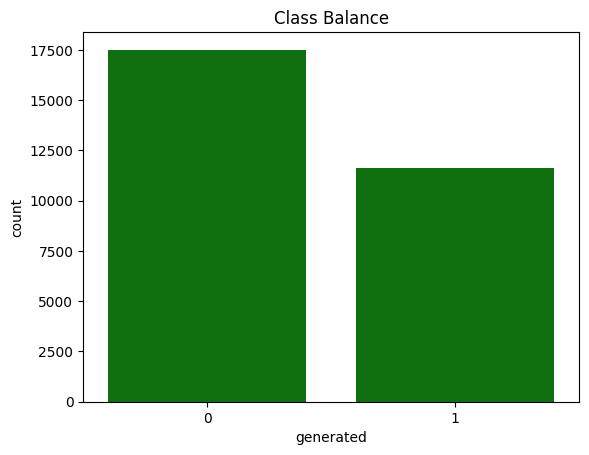

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='generated', data=essay_df, color='green')
plt.title('Class Balance')
plt.show()

### visualizing word coumts for the two classes

In [15]:
from wordcloud import WordCloud

human_text = ' '.join(essay_df[essay_df['generated'] == 0]['text'])
ai_text = ' '.join(essay_df[essay_df['generated'] == 1]['text'])

wordcloud_human = WordCloud(width=800, height=400, background_color='white').generate(human_text)
wordcloud_ai = WordCloud(width= 800, height=400, background_color='black').generate(ai_text)

#### displaying the human wordcloud

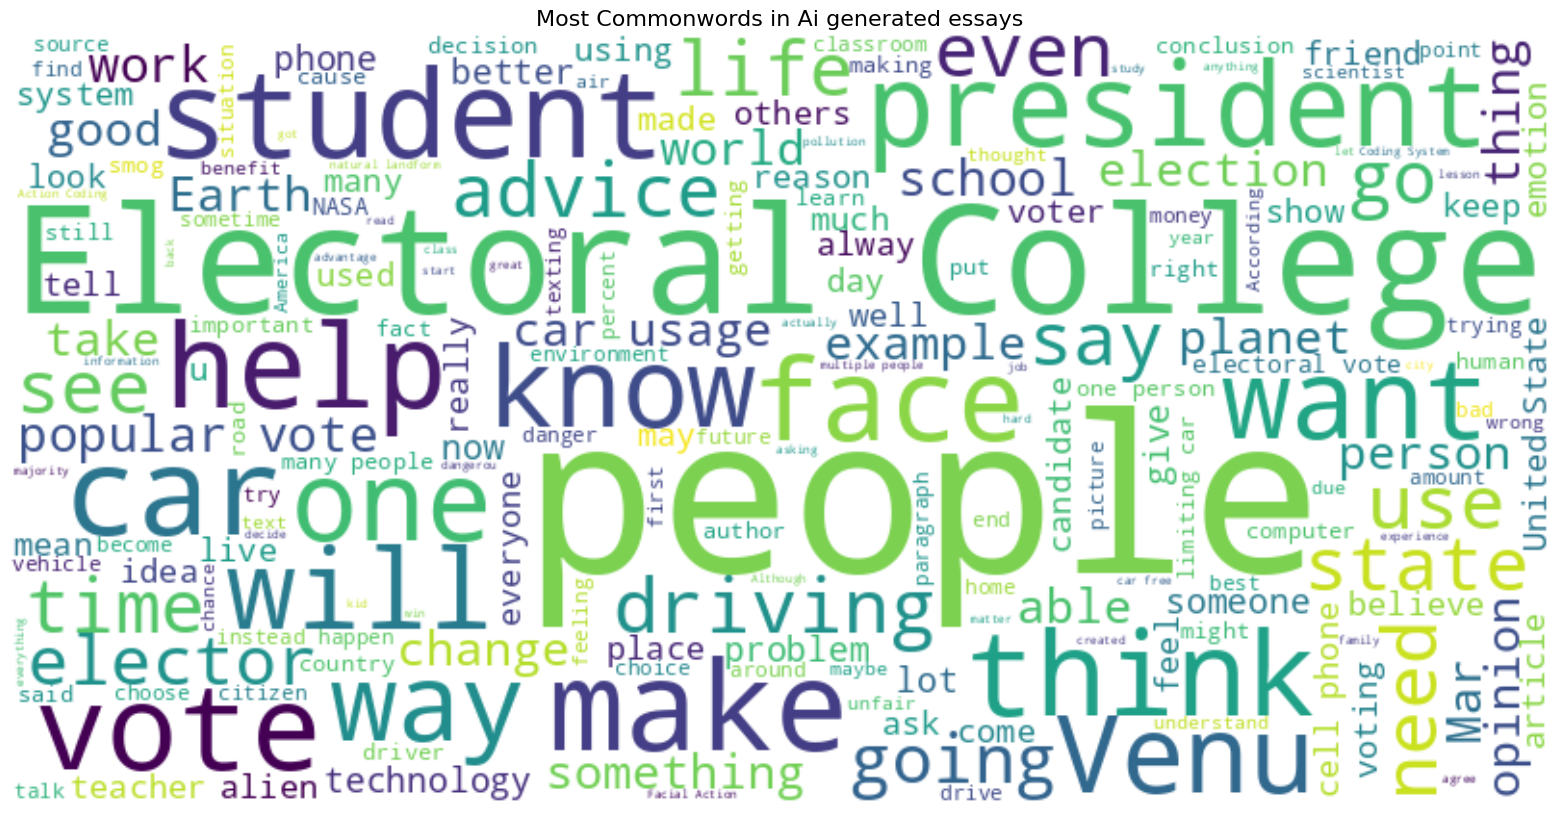

In [16]:
plt.figure(figsize=(20, 10))

plt.imshow(wordcloud_human, interpolation='bilinear')
plt.title('Most Commonwords in human essays', fontsize=16)
plt.axis('off')
plt.show()

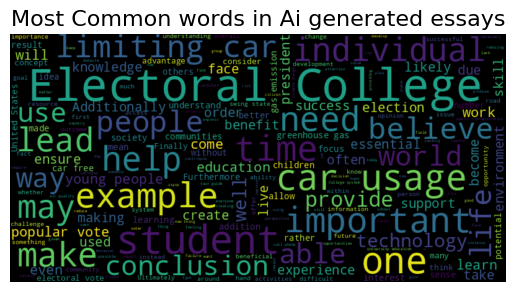

In [18]:
plt.imshow(wordcloud_ai, interpolation='bilinear')
plt.title('Most Common words in Ai generated essays', fontsize=16)
plt.axis('off')
plt.show()

## 2. Displaying the distribution of essay lengths

the first part creates a new column word_count and then visualizes its distribution for both classes using a histogram

In [20]:
essay_df['word_count'] = essay_df['text'].str.split().str.len()

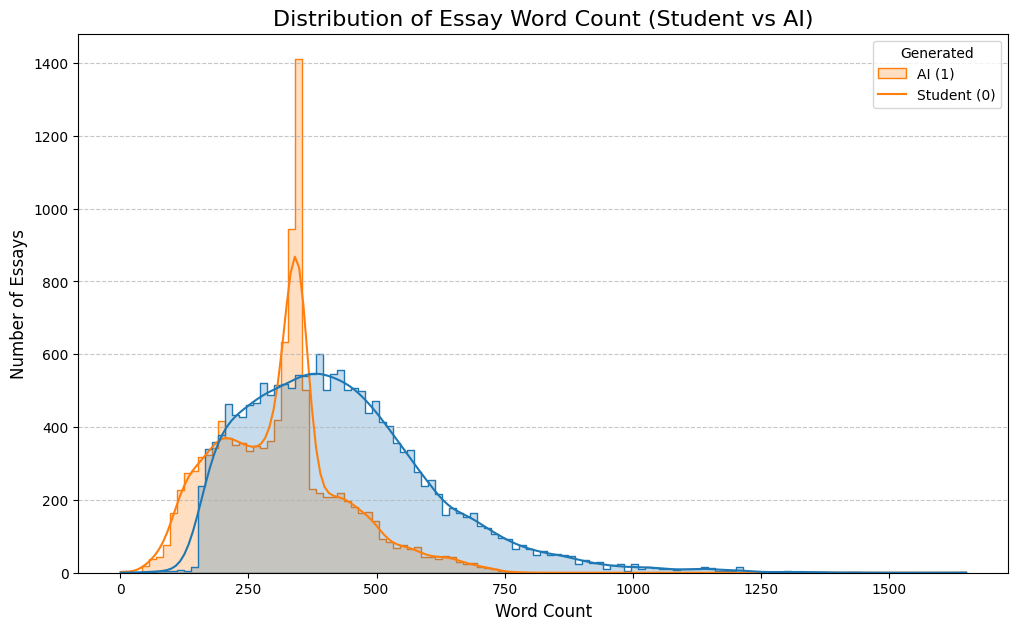

In [22]:
plt.figure(figsize=(12, 7))
sns.histplot(data=essay_df, x='word_count', hue='generated', kde=True, element='step')
plt.title('Distribution of Essay Word Count (Student vs AI)', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Number of Essays', fontsize=12)
plt.legend(title='Generated', labels=['AI (1)', 'Student (0)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Preprocessing
### removal of duplicated values, encodingm scaling, text processing, datetime features, feature enineering, dimensionality reduction

In [23]:
## dropping duplicates
essay_df = essay_df.drop_duplicates(subset=['text'])

In [24]:
print(essay_df.duplicated().sum())

0


In [25]:
essay_df.head(10)

,text,generated,word_count
0,Car-free cities have become a subject of incre...,1,575
1,"Car Free Cities Car-free cities, a concept ga...",1,513
2,A Sustainable Urban Future Car-free cities ...,1,512
3,Pioneering Sustainable Urban Living In an e...,1,519
4,The Path to Sustainable Urban Living In an ...,1,511
5,A Paradigm Shift in Urban Living In an era ...,1,511
6,Revolutionizing Urban Living In an age defi...,1,507
7,Pioneering Sustainable Urban Living In an a...,1,492
8,Reimagining Urban Living In a rapidly urban...,1,475
9,A Vision of Urban Sustainability In our rap...,1,519
